### Stock Trading Strategy using Classification Algorithms to Predict Market Movements and Backtesting

In [1]:
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
from xgboost import XGBClassifier
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import datetime
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData
import plotly.graph_objects as go
import mplfinance as fplt
import warnings

# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

d:\code\python\pyfolio\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
# this is to display images in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Data Gathering

In [3]:
# ticker and the start and end dates for testing
# ticker = '^NSEI' # Nifty 50 benchmark
# start = datetime.datetime(2010, 1, 1)
# end = datetime.datetime(2020, 7, 31)

start = '2021-01-01'
end = '2021-12-12'

In [4]:
# download ticker ‘Adj Close’ price from yahoo finance
# stock =  yf.download(ticker, progress=True, actions=True,start=start, end=end)['Adj Close']
# stock = pd.DataFrame(stock)
# stock.rename(columns = {'Adj Close':ticker}, inplace=True)
# stock.head(2)

In [5]:
from lutils.stock import LTdxHq

In [6]:
ltdxhq = LTdxHq()

In [7]:
code = '603636' # 000032 300142 603636 600519
ticker = code

df = ltdxhq.get_k_data_daily(code) # , start=start, end=end)
# df.index = pd.to_datetime(df.index)

prices = df
stock = pd.DataFrame(df.close)

stock.rename(columns = {'close': ticker}, inplace=True)
stock.head(2)

,603636
date,
2014-12-30,4.48
2014-12-31,4.93


In [9]:
fplt.plot?

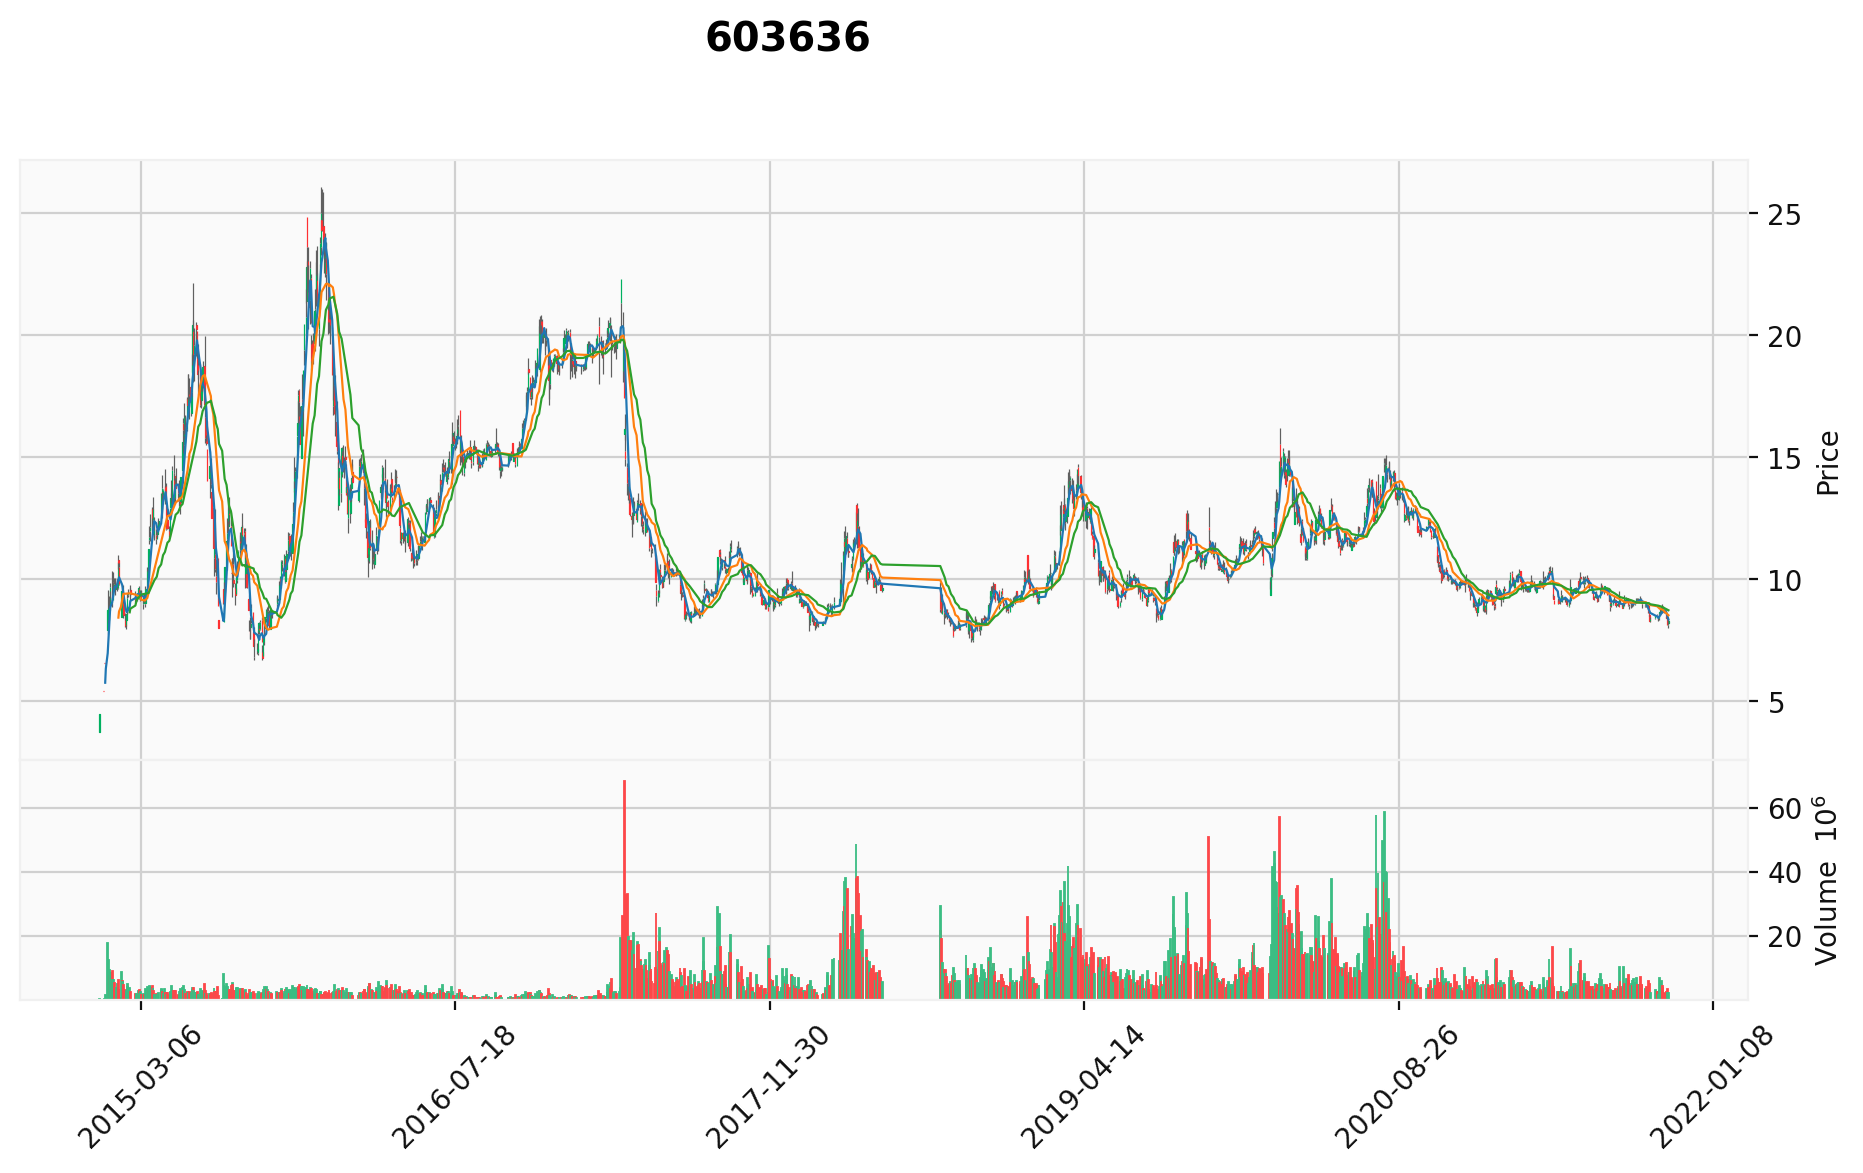

In [10]:
fplt.plot(df, # ['2021-01-01':]
          type='candle', 
          style='yahoo', # style='charles', 
          title=ticker, 
          ylabel='Price', 
          volume=True, 
          show_nontrading=True, 
          mav=(6, 21, 33), 
          figsize=(12,6),
          datetime_format='%Y-%m-%d',
         )

In [11]:
# fig = go.Figure(data=[go.Candlestick(x=df.index,
#                 open=df.open,
#                 high=df.high,
#                 low=df.low,
#                 close=df.close)])

# fig.show()

In [12]:
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.head(3)

,603636,returns,direction
date,,,
2014-12-31,4.93,0.095716,1
2015-01-05,5.42,0.094757,1
2015-01-06,5.96,0.094975,1


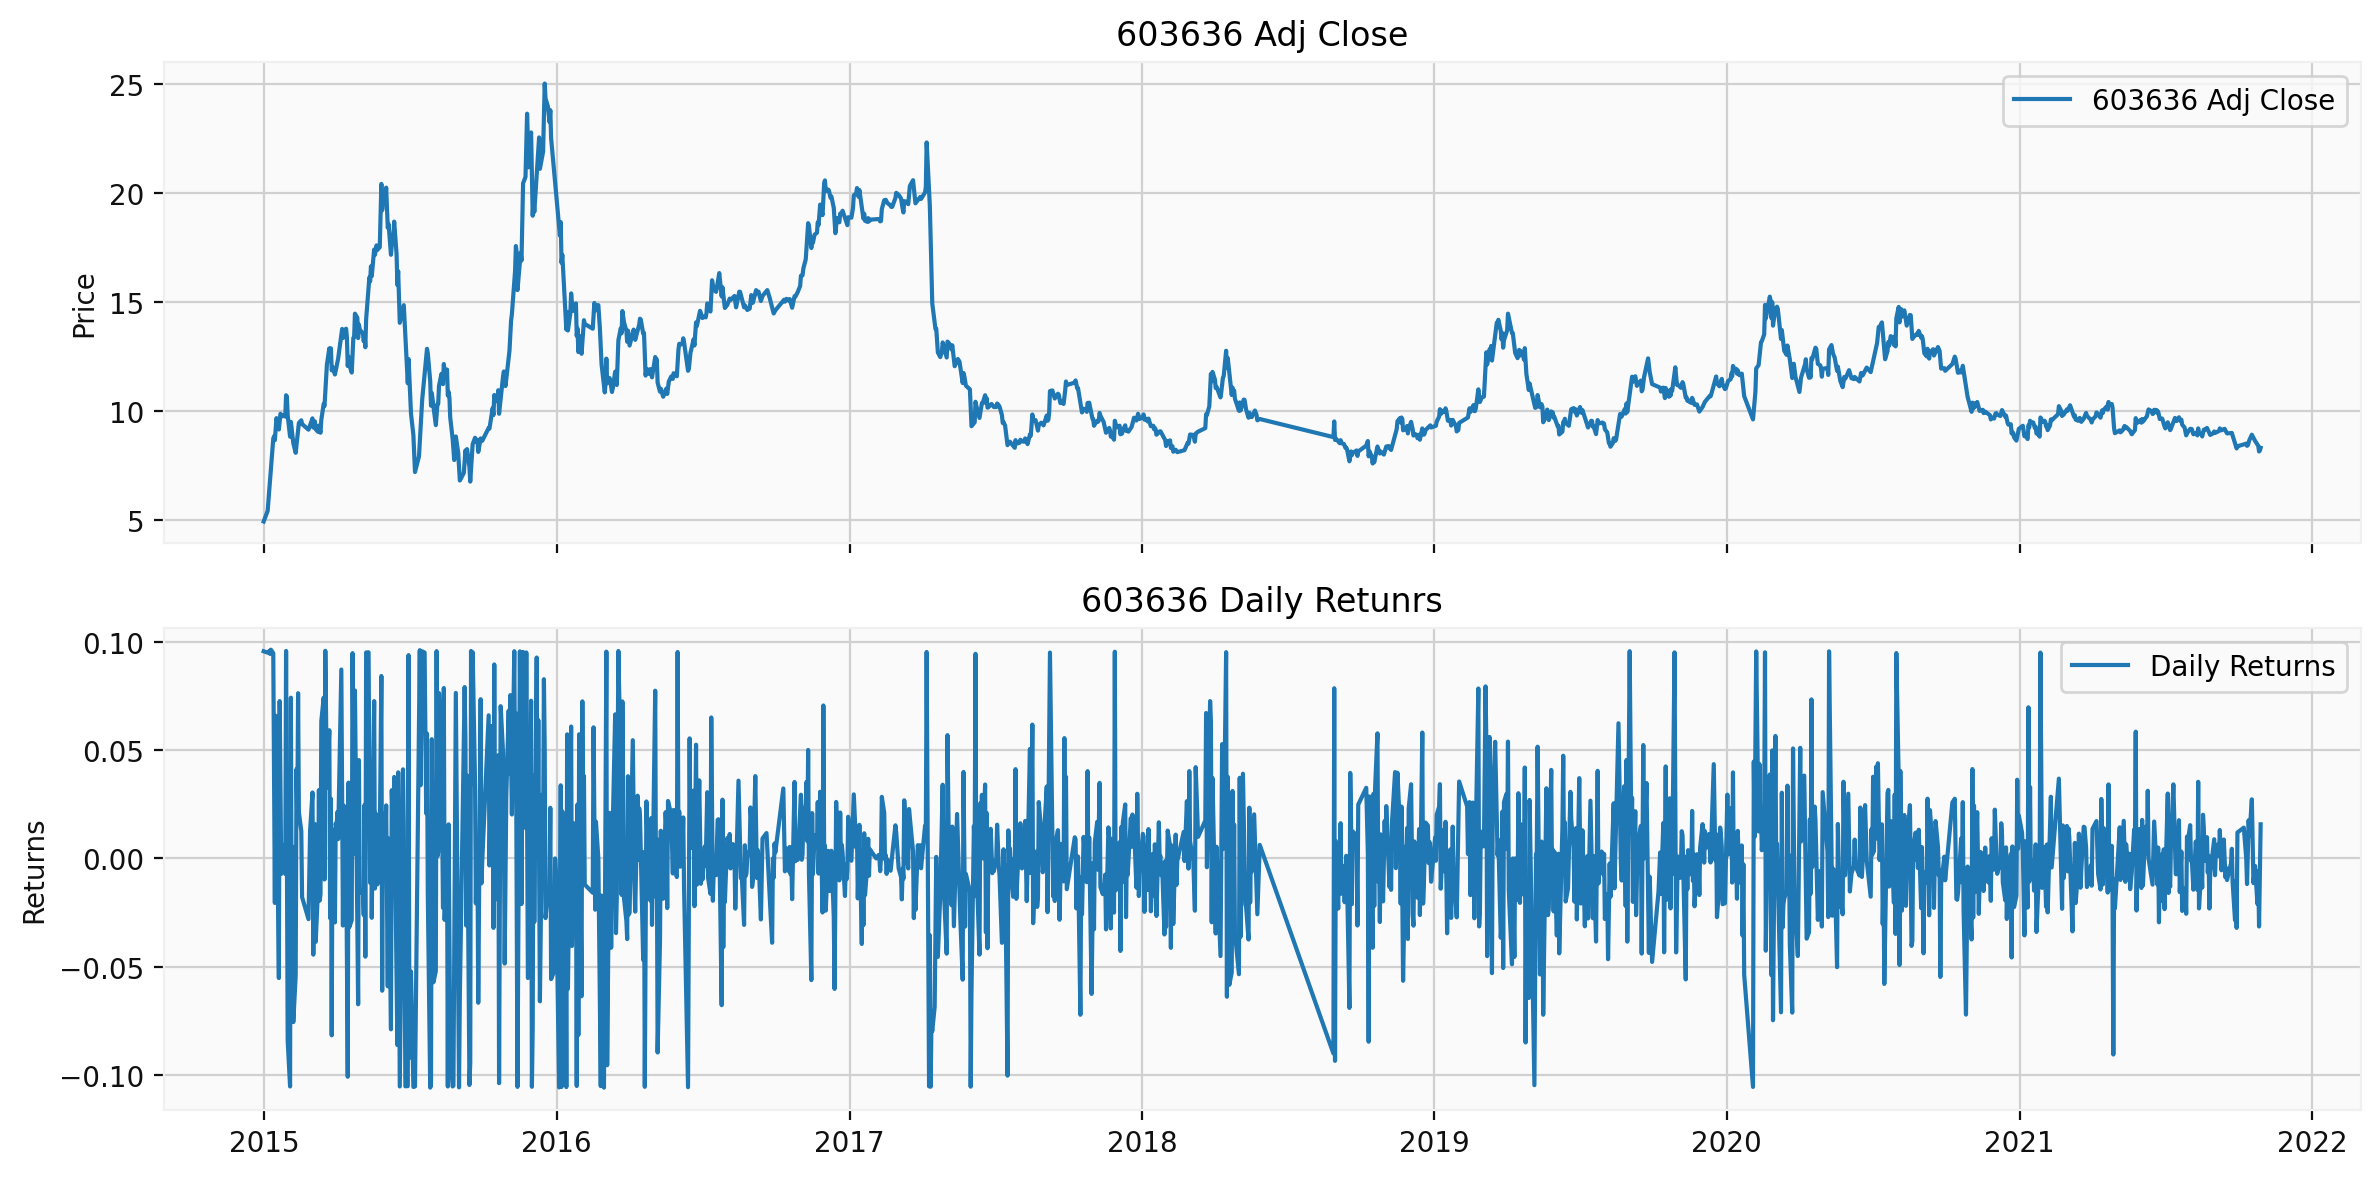

In [13]:
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock[ticker], label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Adj Close', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()

plt.tight_layout()
# plt.savefig('images/chart1', dpi=300)
plt.show()

### Feature Engineering

In [14]:
# define the number of lags
lags = [1, 2, 3, 4, 5]

In [15]:
# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)

stock.dropna(inplace=True)
stock.head(2)

,603636,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5
date,,,,,,,,
2015-01-09,7.94,0.096444,1,0.094478,0.095920,0.094975,0.094757,0.095716
2015-01-12,8.73,0.094852,1,0.096444,0.094478,0.095920,0.094975,0.094757


In [16]:
# cols

In [17]:
# function to transform the lag returns to binary values (0,+1)
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append(col_bin)

In [18]:
create_bins(stock)
stock[cols + cols_bin].head(2)

,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rtn_lag1_bin,rtn_lag2_bin,rtn_lag3_bin,rtn_lag4_bin,rtn_lag5_bin
date,,,,,,,,,,
2015-01-09,0.094478,0.095920,0.094975,0.094757,0.095716,1,1,1,1,1
2015-01-12,0.096444,0.094478,0.095920,0.094975,0.094757,1,1,1,1,1


In [19]:
test = stock.loc['2021-09-01':]
stock = stock.loc[:'2021-09-01']

### Build and Apply Classification Machine Learning Algorithms

Select Logistic regression, Gaussian Naive Bayes, Support Vector Machine, Random Forest, and MLP Classifier approaches to predict the market direction. Please refer sklearn documentation for detail on these and other algorithms.
https://scikit-learn.org/stable/index.html

In [20]:
# create a dictionary of selected algorithms
models = {
    'log_reg': linear_model.LogisticRegression(),
    'gauss_nb': GaussianNB(),
    'svm': SVC(),
    'random_forest': RandomForestClassifier(max_depth=25, n_estimators=400),
    'MLP' : MLPClassifier(activation='relu', solver='adam', alpha=0.0001, max_iter=4000), # MLPClassifier(max_iter=500), 
#     'XGBoost': XGBClassifier(),
}

In [21]:
# function that fits all models.
def fit_models(data):
    mfit = {model: models[model].fit(data[cols_bin], data['direction']) for model in models.keys()}

In [22]:
# function that predicts (derives all position values) from the fitted models
def derive_positions(data):
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [23]:
# function to evaluate all trading strategies
def evaluate_strats(data):
    global strategy_rtn
    strategy_rtn = []
    for model in models.keys():
        col = 'strategy_' + model
        data[col] = data['pos_' + model] * data['returns']
        strategy_rtn.append(col)
    strategy_rtn.insert(0, 'returns')

In [24]:
# fit the models
fit_models(stock)

In [25]:
# derives all position values
derive_positions(stock)
derive_positions(test)

In [26]:
# evaluate all trading strategies by multiplying predicted directions to actual daily returns
evaluate_strats(stock)
evaluate_strats(test)

In [27]:
# calculate total return and std. deviation of each strategy
print('\nTotal Returns:')
print(test[strategy_rtn].sum().apply(np.exp))
print('\nAnnual Volatility:')
print(test[strategy_rtn].std() * 252 ** 0.5)


Total Returns:
returns                   0.925390
strategy_log_reg          0.782240
strategy_gauss_nb         0.782240
strategy_svm              0.917995
strategy_random_forest    0.901855
strategy_MLP              0.867090
dtype: float64

Annual Volatility:
returns                   0.213278
strategy_log_reg          0.186083
strategy_gauss_nb         0.186083
strategy_svm              0.212663
strategy_random_forest    0.211082
strategy_MLP              0.206452
dtype: float64


In [28]:
# number of trades over time for highest and second highest return strategy
print('Number of trades SVM = ', (test['pos_svm'].diff()!=0).sum())
print('Number of trades Ramdom Forest = ',(test['pos_random_forest'].diff()!=0).sum())

Number of trades SVM =  15
Number of trades Ramdom Forest =  16


In [29]:
# stock[[ticker]+ strategy_rtn].head(2)

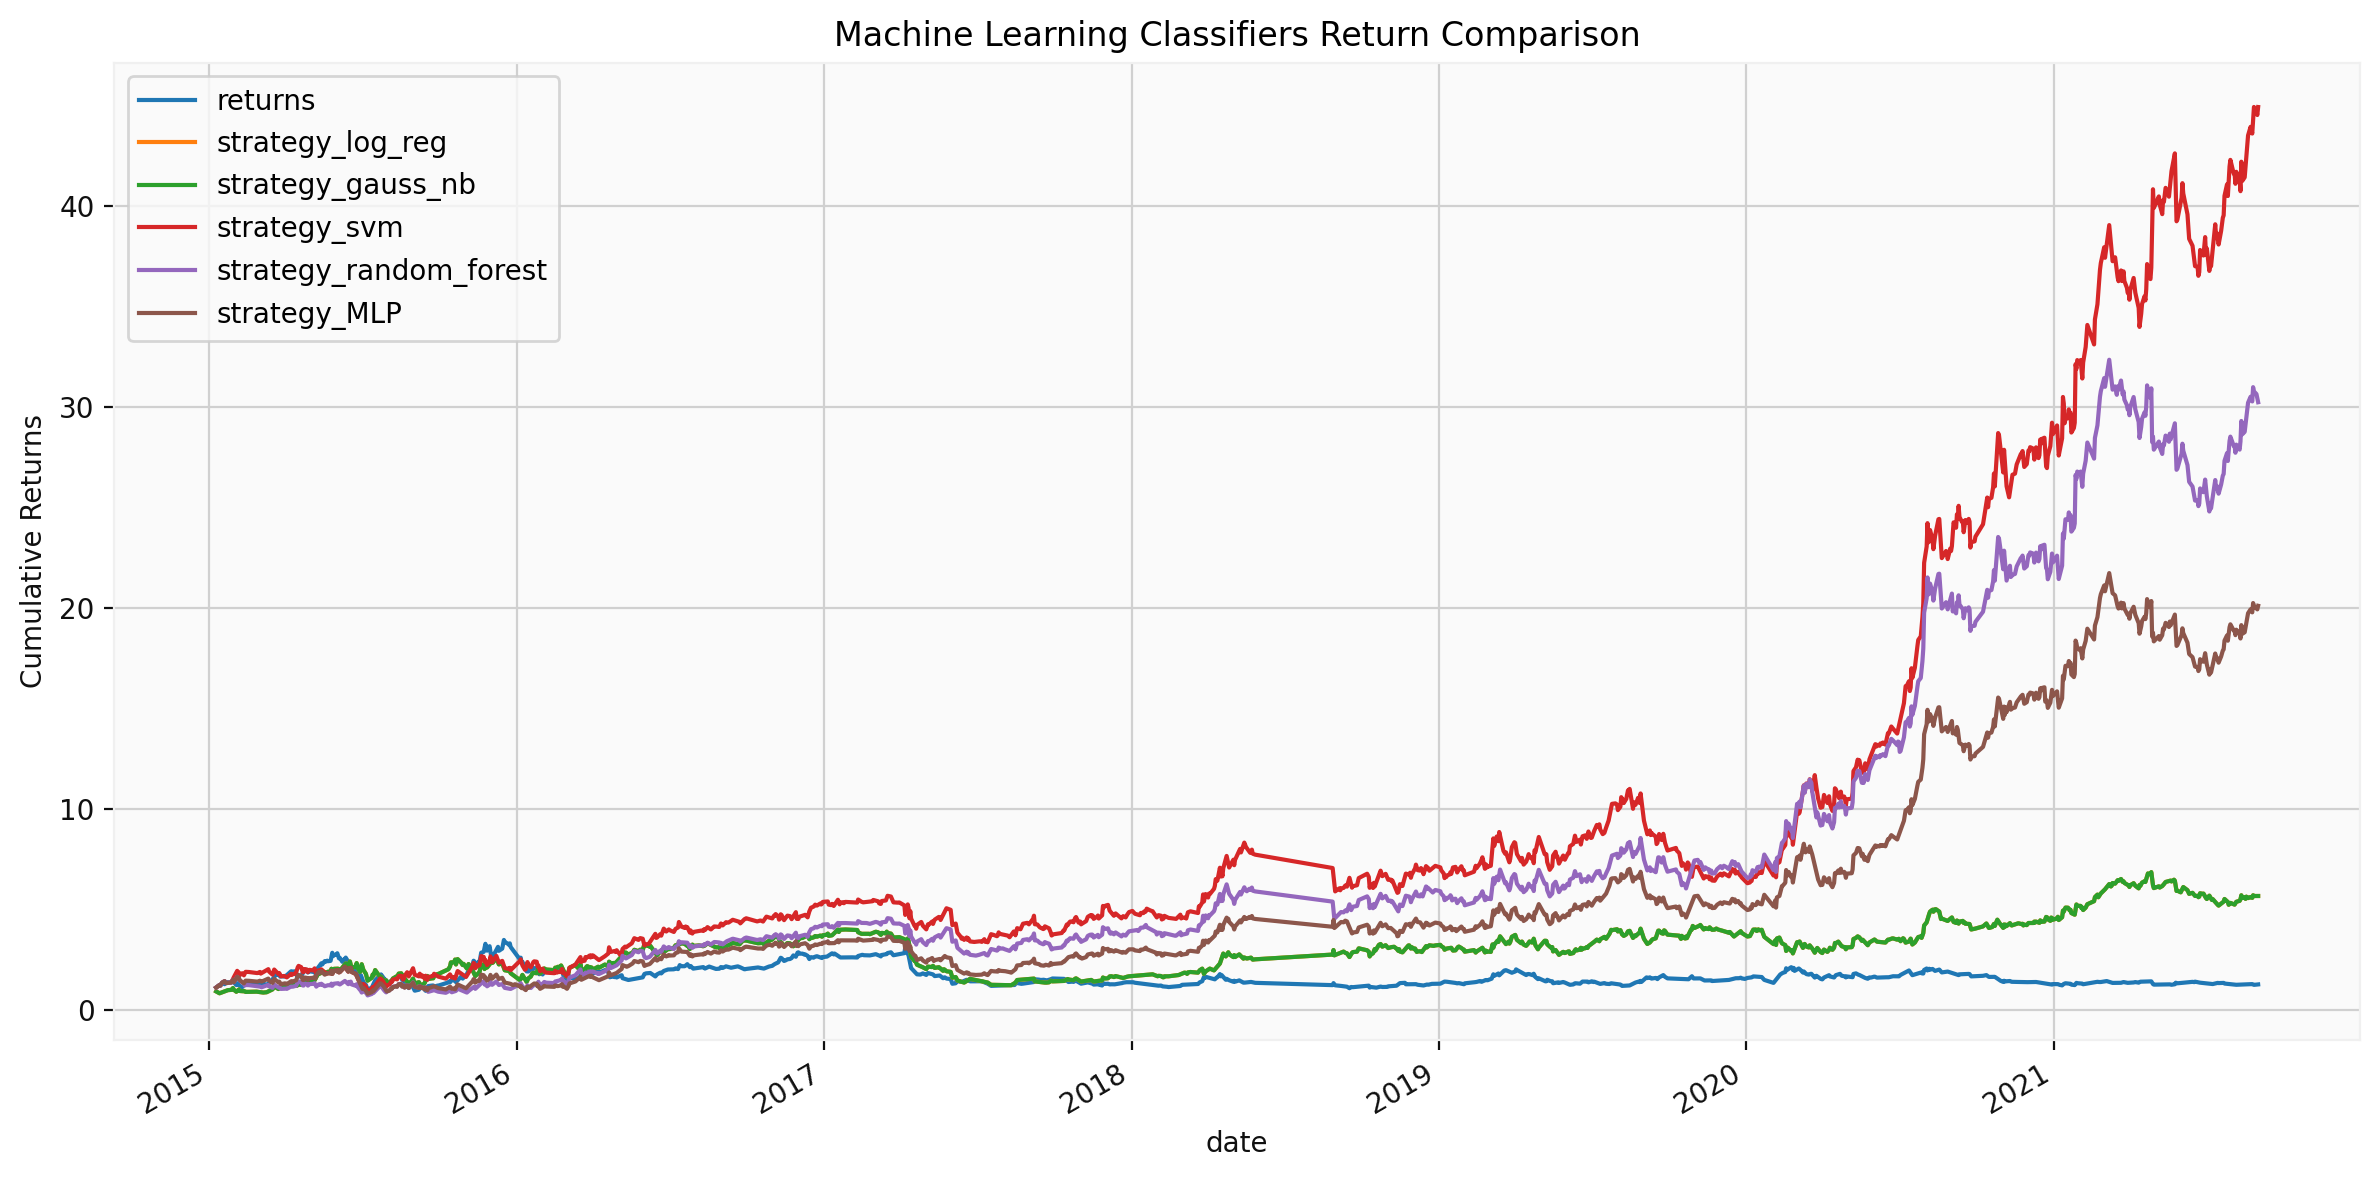

In [30]:
ax = stock[strategy_rtn].cumsum().apply(np.exp).plot(figsize=(12, 6), title = 'Machine Learning Classifiers Return Comparison')
ax.set_ylabel('Cumulative Returns')
ax.grid(True)
plt.tight_layout()
# plt.savefig('images/chart2', dpi=300)
plt.show()

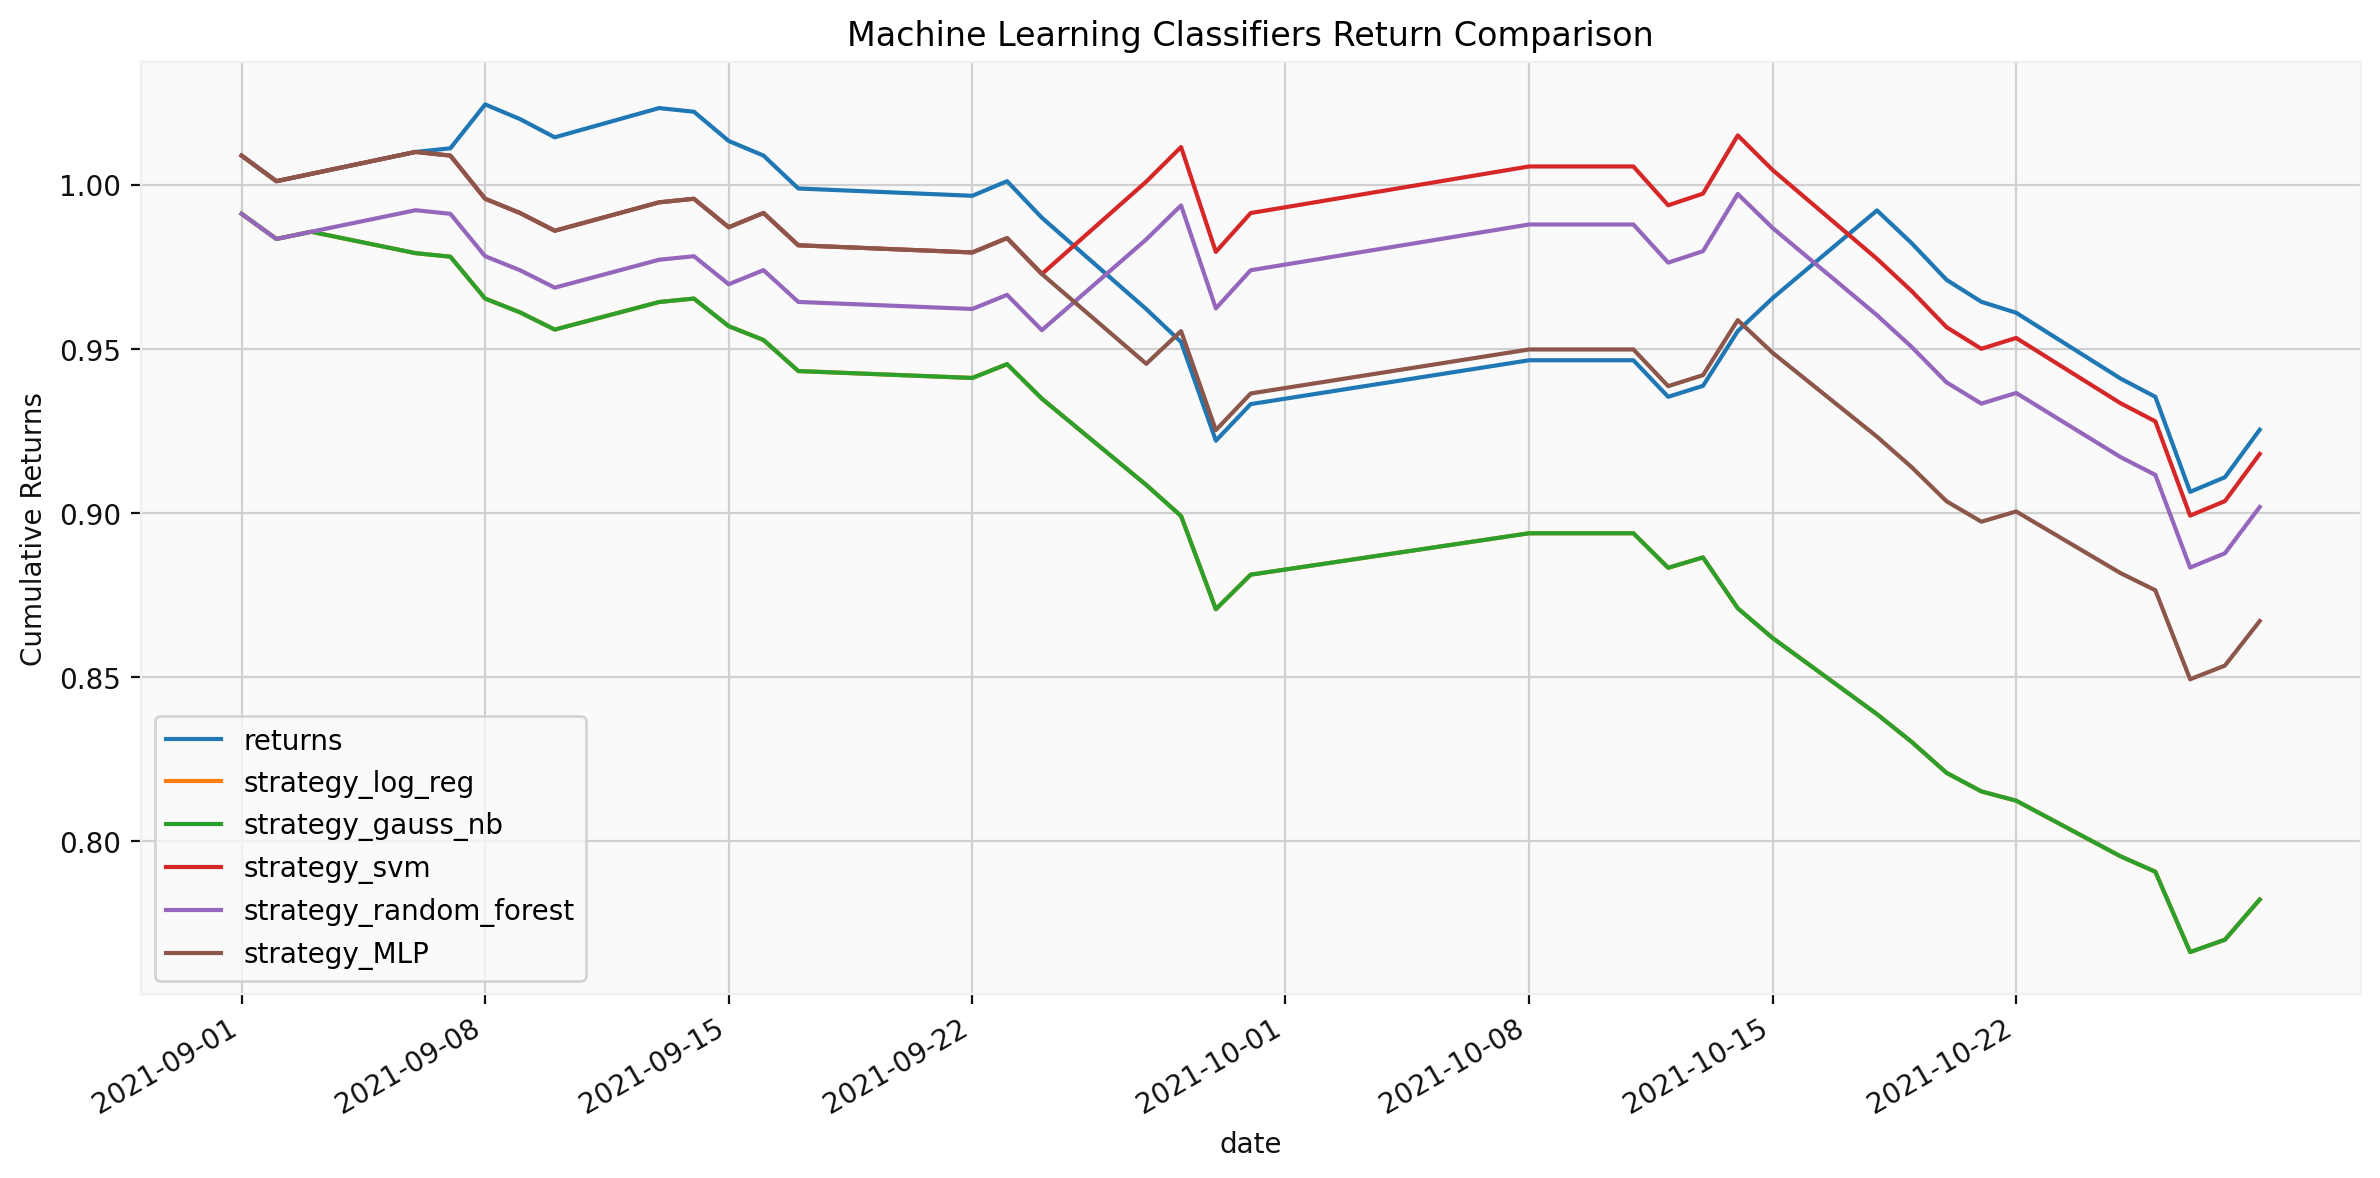

In [31]:
ax = test[strategy_rtn].cumsum().apply(np.exp).plot(figsize=(12, 6), title = 'Machine Learning Classifiers Return Comparison')
ax.set_ylabel('Cumulative Returns')
ax.grid(True)
plt.tight_layout()
# plt.savefig('images/chart2', dpi=300)
plt.show()

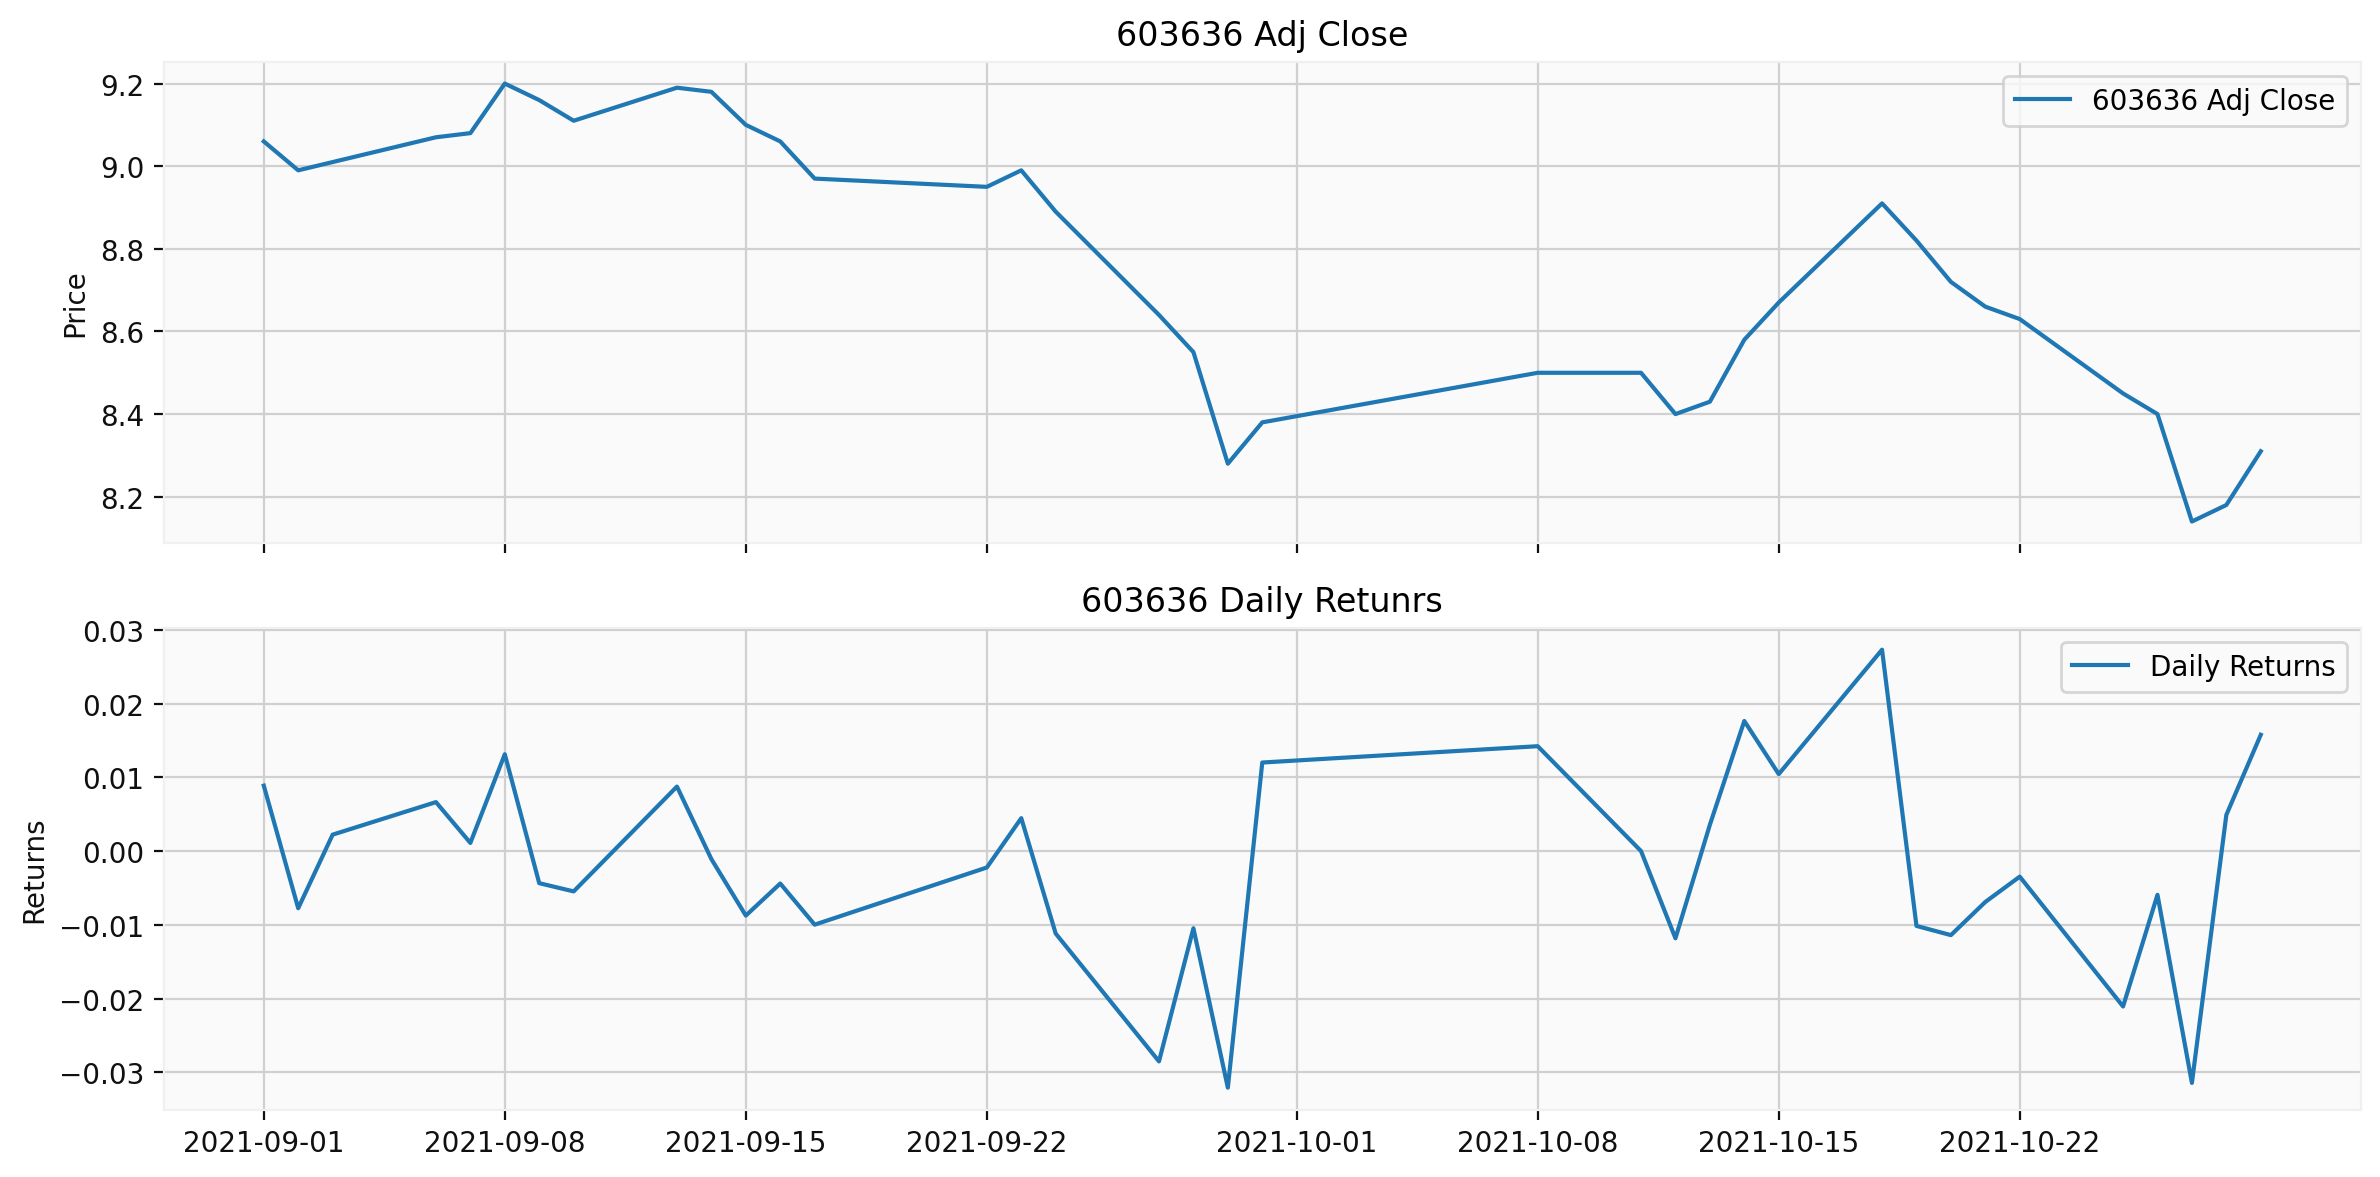

In [32]:
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(test[ticker], label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Adj Close', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(test['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()

plt.tight_layout()
# plt.savefig('images/chart1', dpi=300)
plt.show()

### Backtesting of Selected Strategy using Backtrader

In [33]:
# fetch the daily pricing data from yahoo finance
# prices =  yf.download(ticker, progress=True, actions=True, start=start, end=end)
# prices.head(2)

In [34]:
# rename the columns as needed for Backtrader
# prices.drop(['Close','Dividends','Stock Splits'], inplace=True, axis=1)
# prices.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume',}, inplace=True)

In [35]:
prices.head(3)

,open,close,high,low,volume,amount
date,,,,,,
2014-12-30,3.73,4.48,4.48,3.73,38100.0,819575.0
2014-12-31,4.93,4.93,4.93,4.93,16900.0,400192.0
2015-01-05,5.42,5.42,5.42,5.42,21200.0,552260.0


In [36]:
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
# predictions = stock['strategy_svm']
# predictions = pd.DataFrame(predictions)
# predictions.rename(columns = {'strategy_svm':'predicted'}, inplace=True)
# prices = predictions.join(prices, how='right').dropna()
# prices.head(2)

In [37]:
# # strategy_log_reg, strategy_gauss_nb, strategy_svm, strategy_random_forest, strategy_MLP, strategy_XGBoost
# strategy_name = 'strategy_XGBoost'
# predictions = stock[strategy_name]
# predictions = pd.DataFrame(predictions)
# predictions.rename(columns = {strategy_name:'predicted'}, inplace=True)
# prices = predictions.join(prices, how='right').dropna()
# prices.head(2)

In [38]:
strategy_names = ['strategy_%s' % m for m in models.keys()]
predictions = test[strategy_names].sum(axis=1)
predictions = pd.DataFrame(predictions)
# predictions.rename(columns = {strategy_name:'predicted'}, inplace=True)
predictions.columns = ['predicted']
prices = predictions.join(prices, how='right').dropna()
prices.tail(10)

,predicted,open,close,high,low,volume,amount
date,,,,,,,
2021-10-18,-0.136527,8.67,8.91,8.98,8.61,5839206.0,51554704.0
2021-10-19,-0.050762,8.89,8.82,8.89,8.71,3622530.0,31819400.0
2021-10-20,-0.057013,8.88,8.72,8.92,8.70,4278266.0,37573888.0
2021-10-21,-0.034523,8.67,8.66,8.79,8.64,2189268.0,19041162.0
2021-10-22,0.003470,8.63,8.63,8.70,8.62,1957257.0,16938460.0
2021-10-25,-0.105390,8.62,8.45,8.62,8.43,2696680.0,22857232.0
2021-10-26,-0.029674,8.47,8.40,8.47,8.37,2031200.0,17070384.0
2021-10-27,-0.157208,8.40,8.14,8.40,8.13,3409500.0,28027748.0
2021-10-28,0.024510,8.13,8.18,8.30,8.01,2205798.0,17976188.0


In [39]:
# prices[['predicted']].sum().apply(np.exp)

In [40]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [41]:
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

Strategy: 
1.	Buy when the predicted value is +1 and sell (only if stock is in possession) when the predicted value is -1.
2.	All-in strategy—when creating a buy order, buy as many shares as possible.
3.	Short selling is not allowed

In [42]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_predicted < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [43]:
# instantiate SignalData class
data = SignalData(dataname=prices)

In [44]:
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=ticker)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.0005)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [45]:
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2021-09-03, BUY CREATED --- Size: 11123, Cash: 100000.00, Open: 8.99, Close: 9.01
2021-09-03, Order Failed
2021-09-06, BUY CREATED --- Size: 11111, Cash: 100000.00, Open: 9.0, Close: 9.07
2021-09-06, Order Failed
2021-09-13, BUY CREATED --- Size: 10976, Cash: 100000.00, Open: 9.11, Close: 9.19
2021-09-13, Order Failed
2021-09-14, BUY CREATED --- Size: 10869, Cash: 100000.00, Open: 9.2, Close: 9.18
2021-09-14, Order Failed
2021-09-16, BUY CREATED --- Size: 11025, Cash: 100000.00, Open: 9.07, Close: 9.06
2021-09-16, Order Failed
2021-09-23, BUY CREATED --- Size: 11185, Cash: 100000.00, Open: 8.94, Close: 8.99
2021-09-23, Order Failed
2021-09-28, BUY CREATED --- Size: 11574, Cash: 100000.00, Open: 8.64, Close: 8.55
2021-09-28, Order Failed
2021-09-30, BUY CREATED --- Size: 12062, Cash: 100000.00, Open: 8.29, Close: 8.38
2021-09-30, Order Failed
2021-10-08, BUY CREATED --- Size: 11904, Cash: 100000.00, Open: 8.4, Close: 8.5
2021-10-08, Order Failed
2021-

In [46]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(2)

index
2021-09-01 00:00:00+00:00    0.0
2021-09-02 00:00:00+00:00    0.0
Name: Strategy, dtype: float64

In [47]:
# get benchmark returns
benchmark_rets= test['returns']
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC')
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'Nifty-50'
benchmark_rets.head(5)

date
2021-09-01 00:00:00+00:00    0.008869
2021-09-02 00:00:00+00:00   -0.007756
2021-09-03 00:00:00+00:00    0.002222
2021-09-06 00:00:00+00:00    0.006637
2021-09-07 00:00:00+00:00    0.001102
Name: Nifty-50, dtype: float64

In [48]:
# get performance statistics for strategy
pf.show_perf_stats(returns)

Start date,2021-09-01
End date,2021-10-29
Total months,1
,Backtest
Annual return,0.0%
Cumulative returns,0.0%
Annual volatility,0.0%
Sharpe ratio,NaN
Calmar ratio,NaN
Stability,0.00
Max drawdown,0.0%


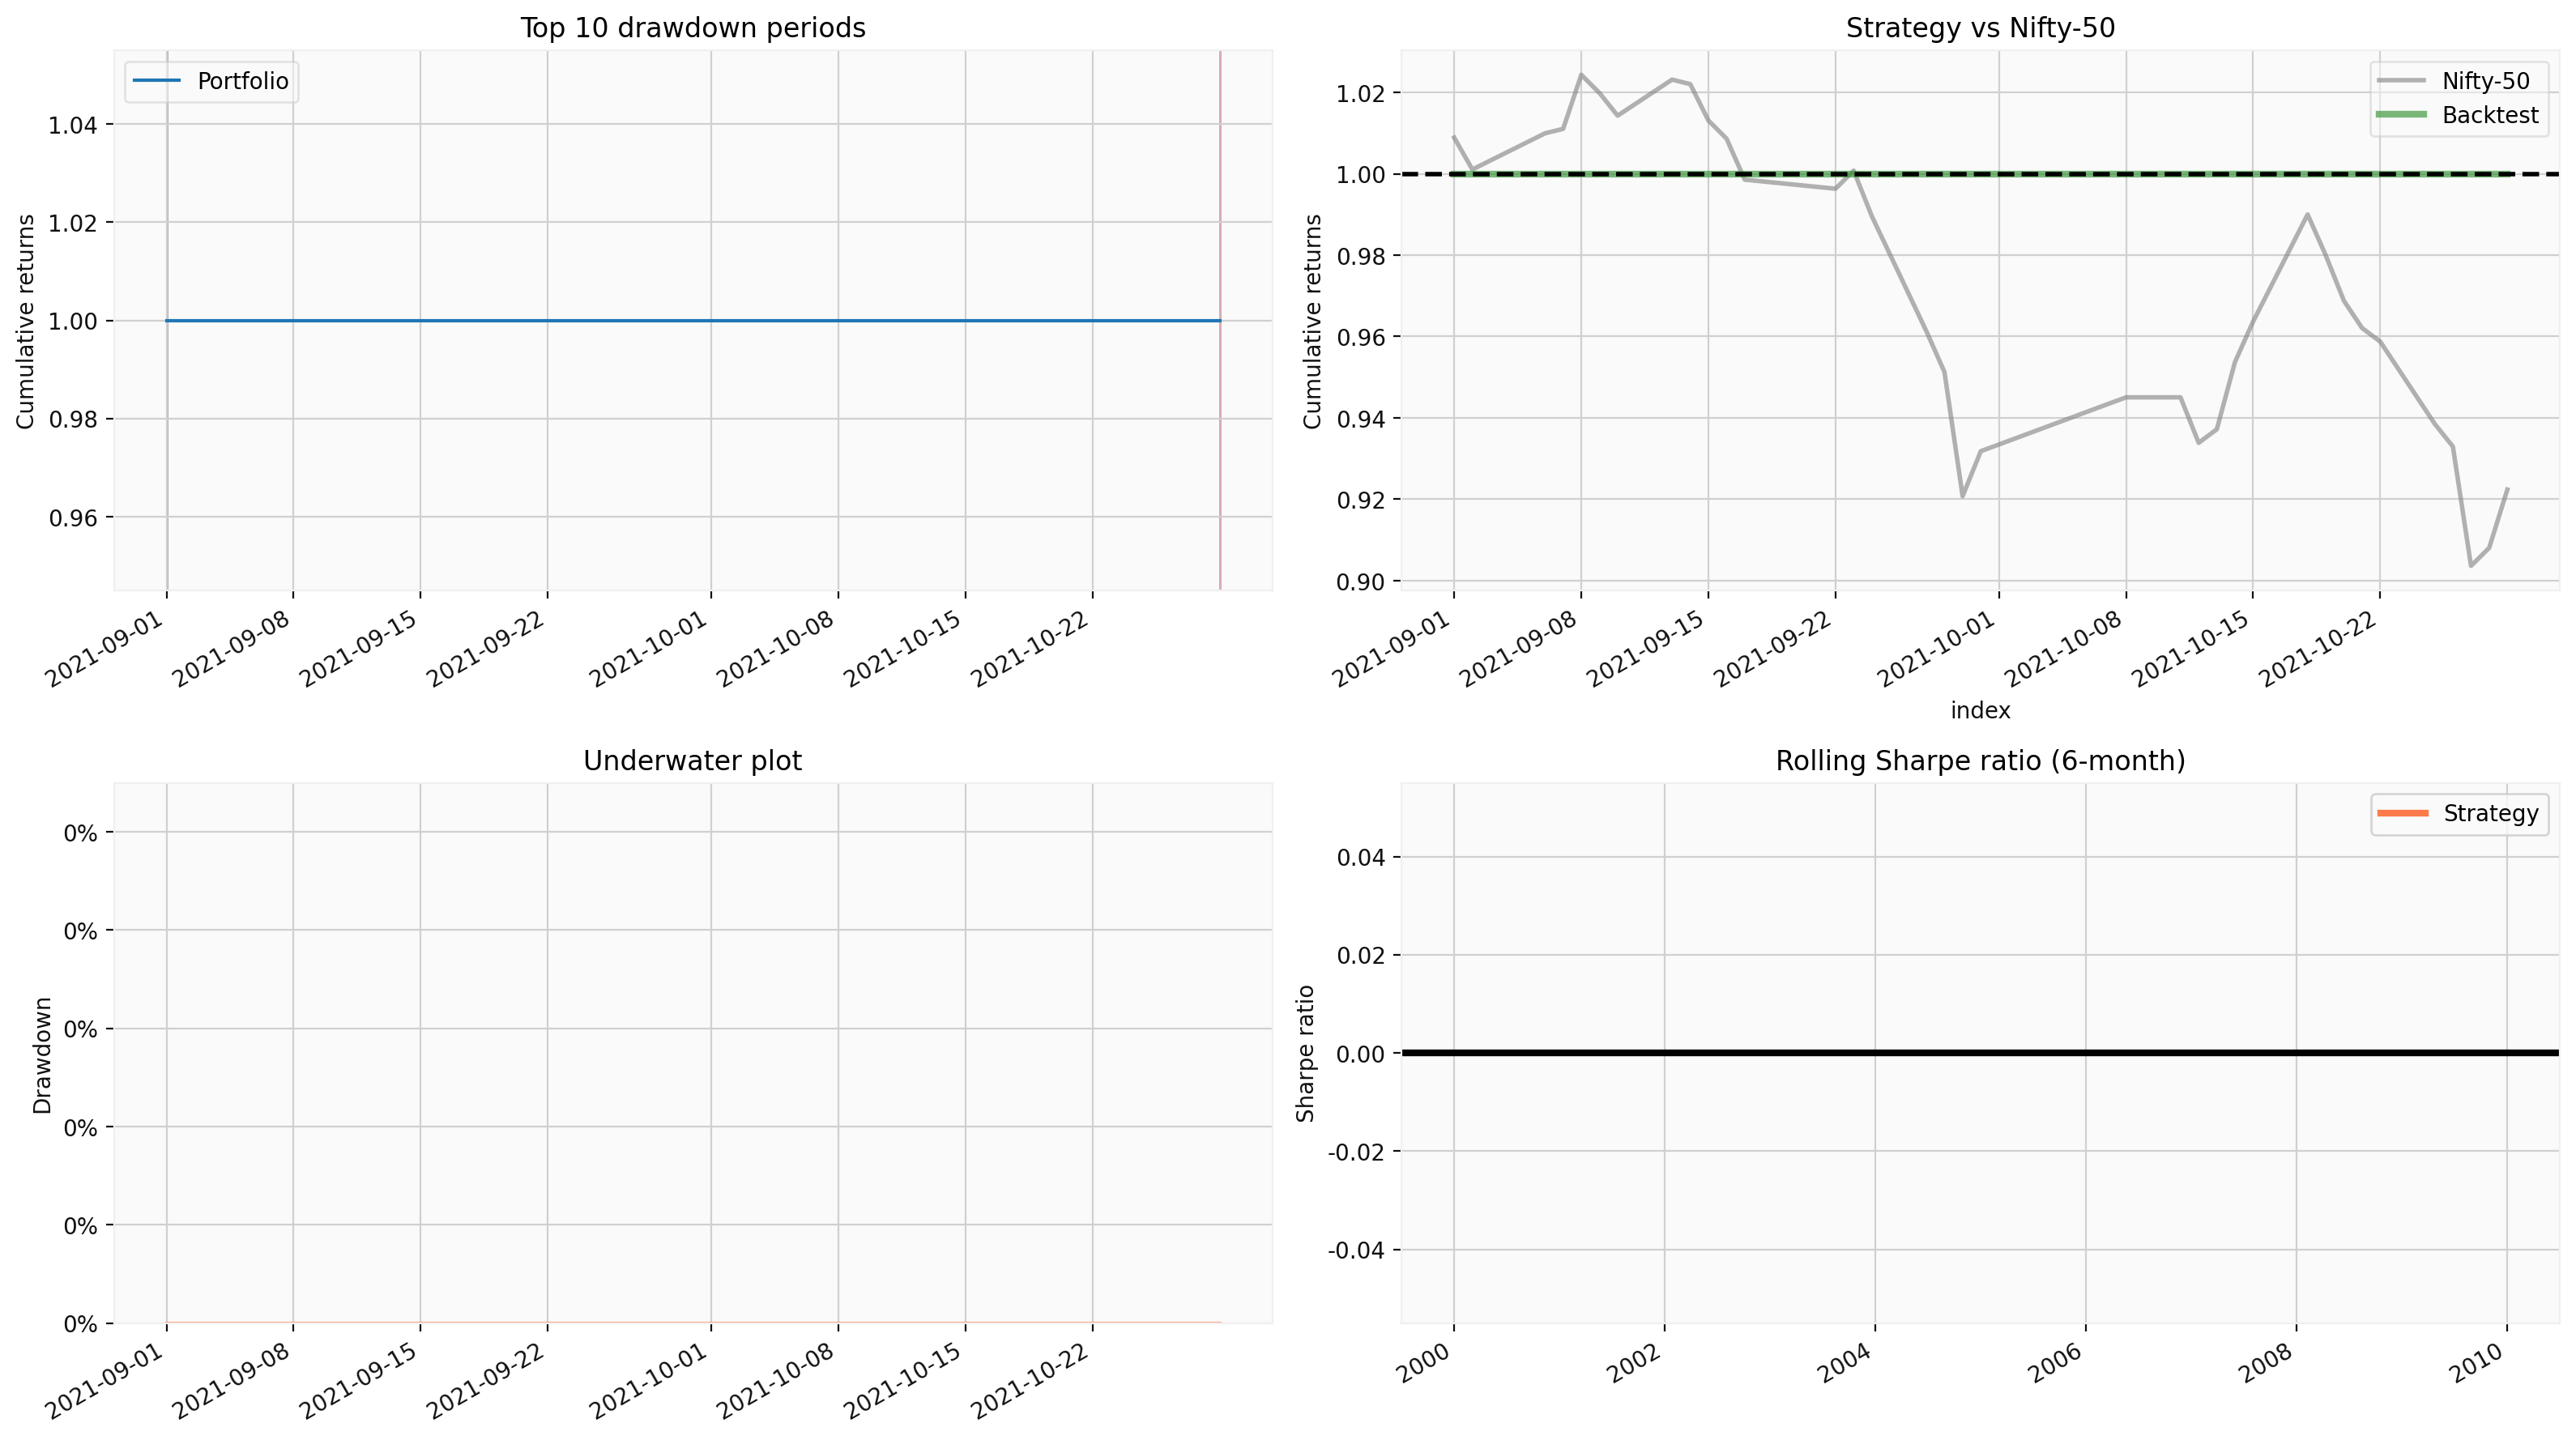

In [49]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_drawdown_periods(returns=returns, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_returns(returns=returns, factor_returns=benchmark_rets, ax=axes[1], title='Strategy vs Nifty-50')
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])
axes[3].grid(True)
# fig.suptitle('Strategy vs Nifty-50 (Buy and Hold)', fontsize=16, y=0.990)

plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('images/chart3', dpi=300)
plt.show()

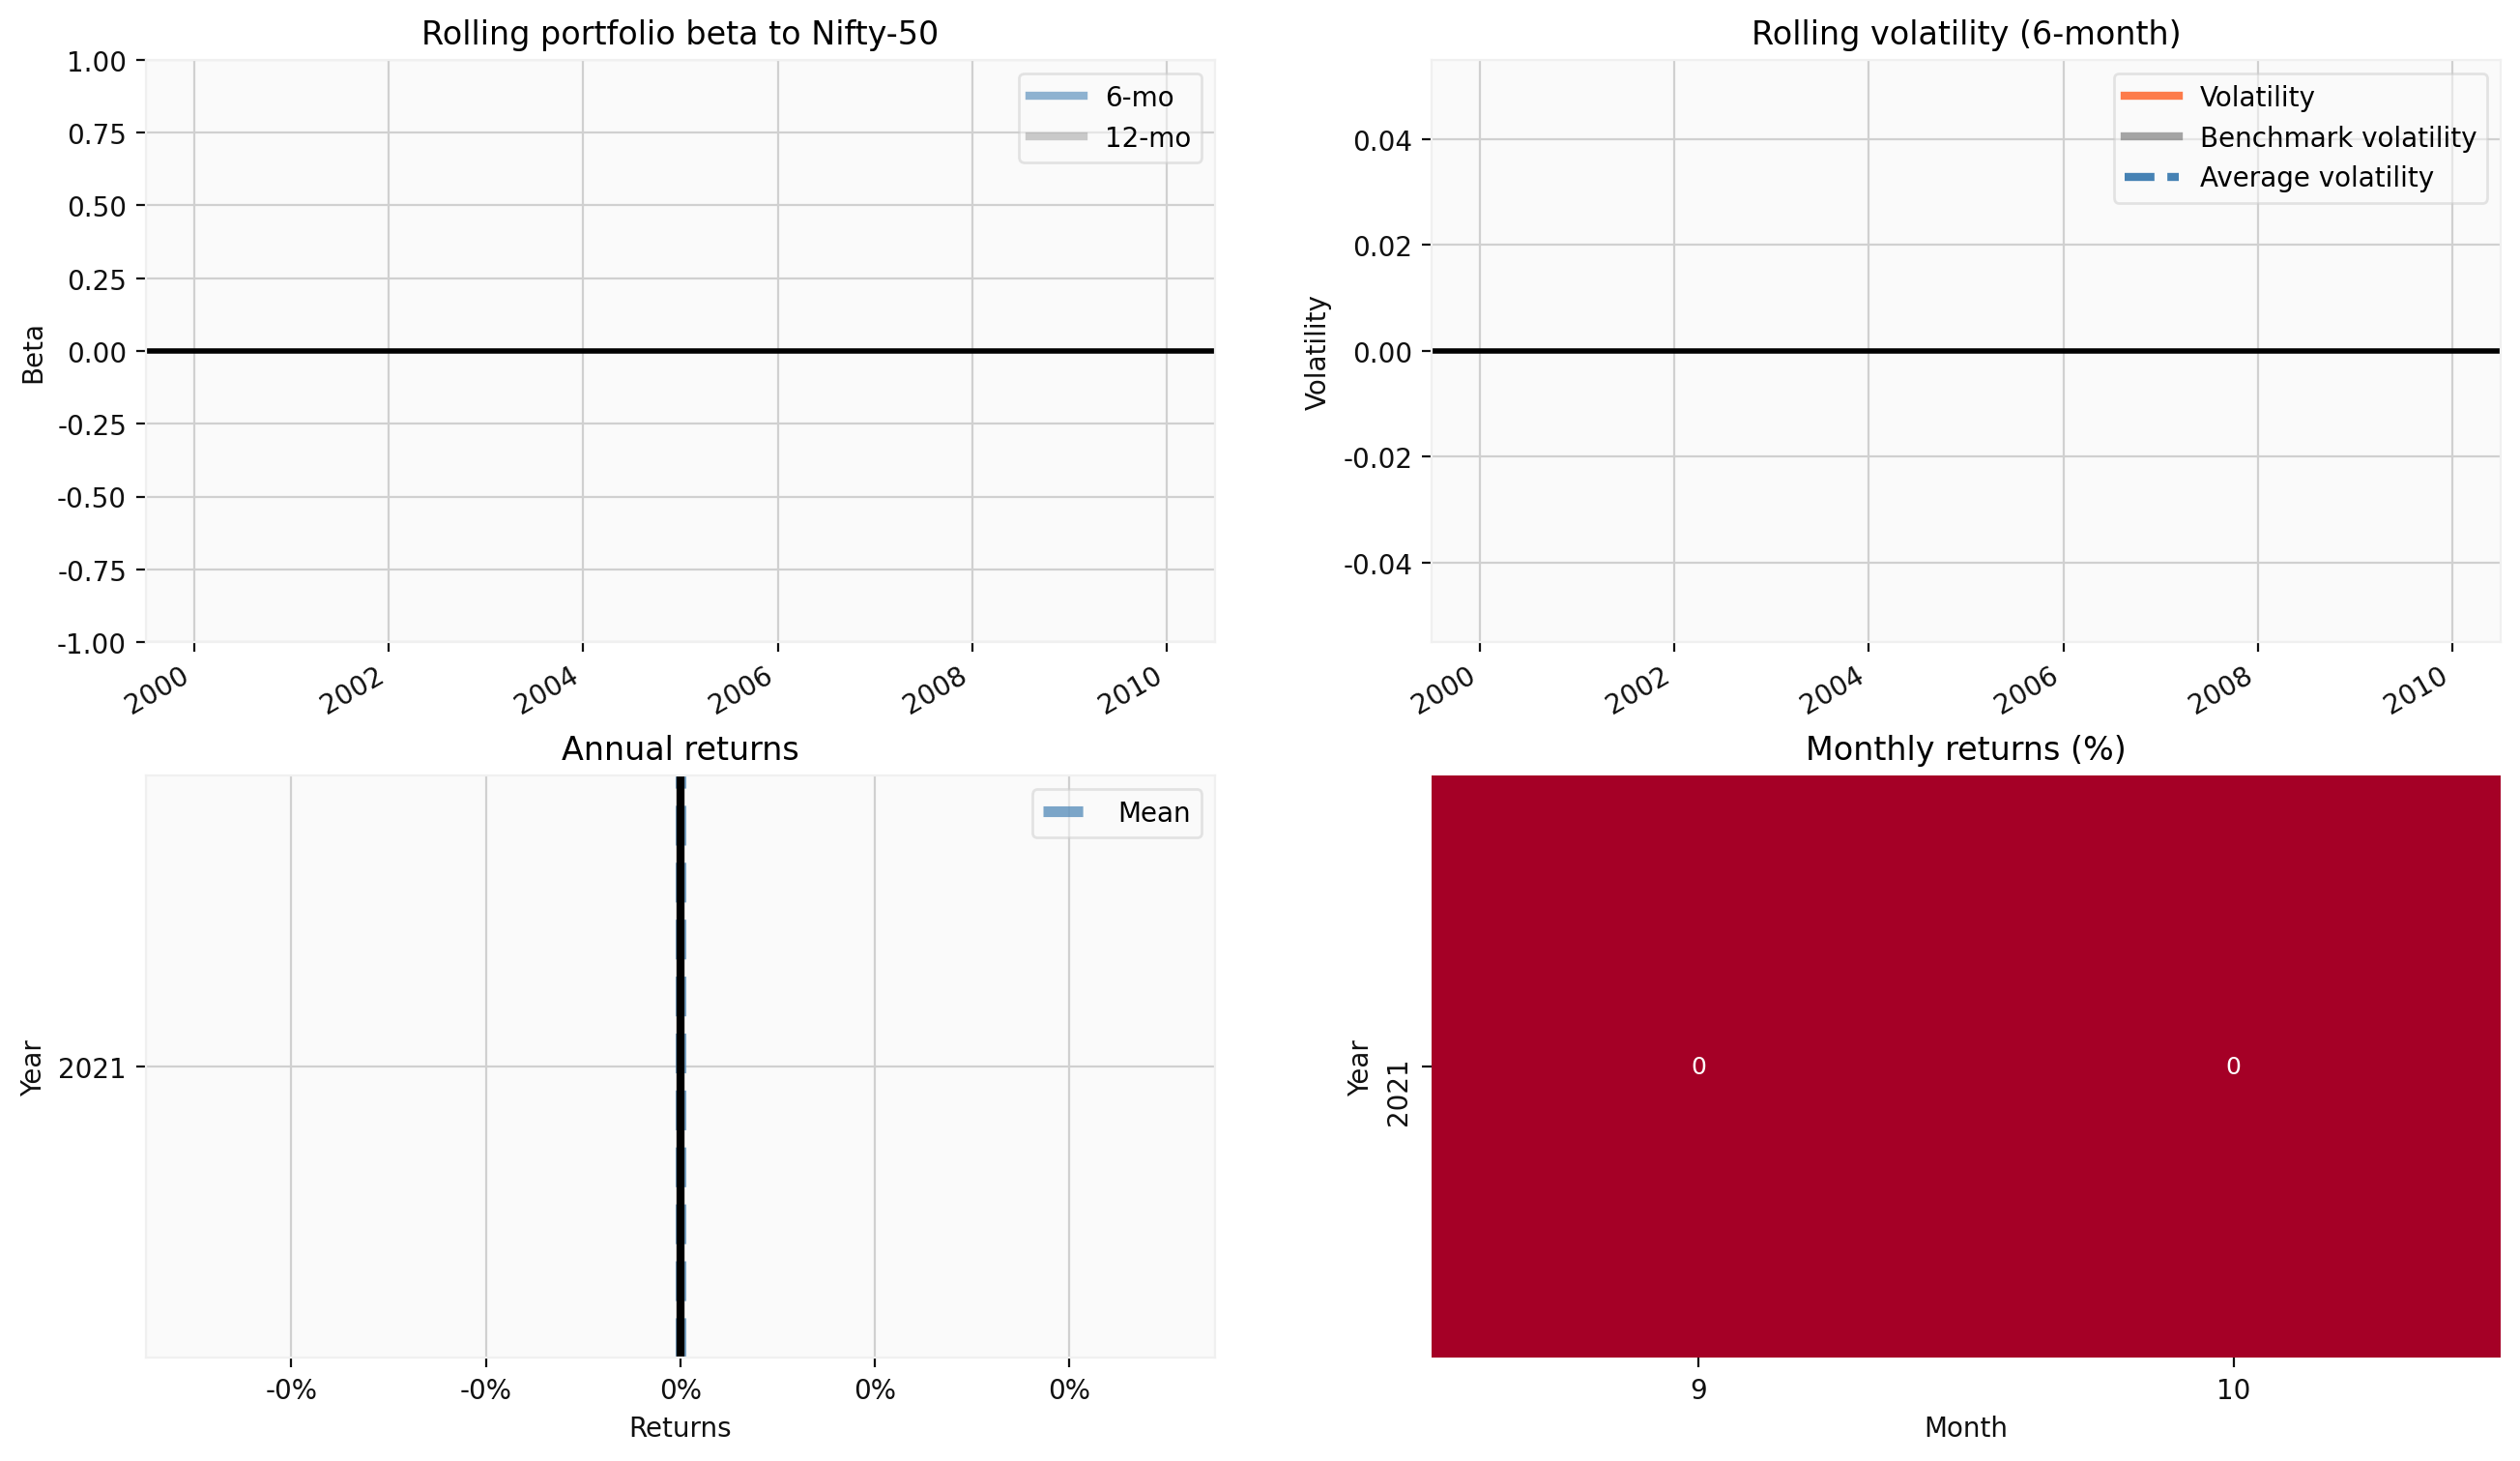

In [50]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
axes[0].grid(True)

pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
axes[1].grid(True)

pf.plot_annual_returns(returns=returns, ax=axes[2])
axes[2].grid(True)

pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)
# fig.suptitle('BL Portfolio vs BSE-SENSEX - 2', fontsize=16, y=1.0)


plt.tight_layout()
# plt.savefig('images/chart4', dpi=300)
plt.show()